In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.patches import FancyArrowPatch

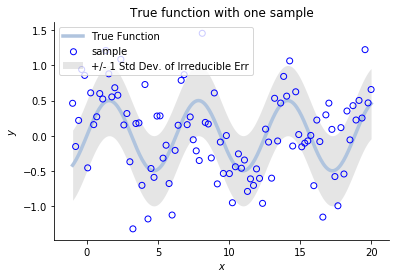

In [2]:
np.random.seed(0)
start = -1
end = 20
n_train = 100
noise_std = .5

x_train = np.linspace(start,end,n_train)
x_test = x_train + (x_train[1]-x_train[0])/2
x_graph = np.linspace(start,end,250)

def true_func(x):
    return np.sin(x)*.5
    
def gen_sample(true_func,x,noise_std):
    norm = np.random.normal(0, noise_std, len(x))
    return true_func(x) + norm

def set_up_fig(x_graph,true_func):

    fig, ax = plt.subplots()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.plot(x_graph, true_func(x_graph),
            linewidth=3.5,color='lightsteelblue',
           label='True Function')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    
    return fig, ax

fig, ax = set_up_fig(x_graph,true_func) 

ax.scatter(x_train,gen_sample(true_func,x_train,noise_std),
          label='sample', zorder=5, facecolors='none',edgecolor='blue')

ax.fill_between(x_graph, true_func(x_graph)+noise_std, true_func(x_graph)-noise_std, 
                alpha=0.2, color='grey',linewidth=0,label='+/- 1 Std Dev. of Irreducible Err')
ax.legend(loc='upper left')
ax.set_title('True function with one sample')

fig.savefig('TrueFunc.png')
pass

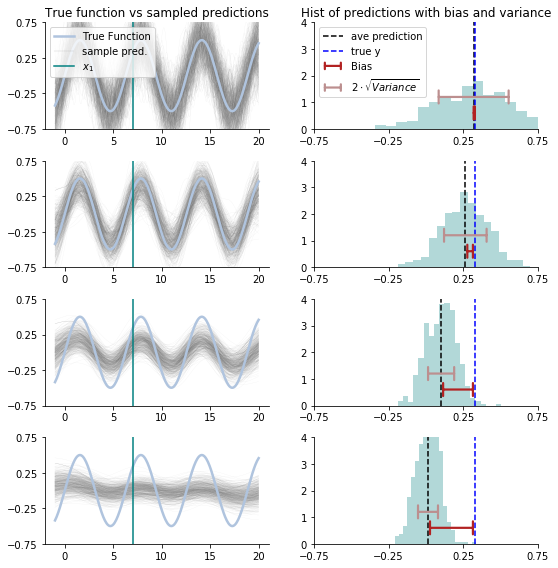

In [4]:
N_samples = 500
width = 1.1
np.random.seed(0)

def form_pred_curve(x_sample, y_sample, x_pred, width):
    
    def norm_dist(dist_mat):
        return (1/np.sqrt(2*np.pi*width**2))*(np.exp(-(1/2)*((dist_mat**2)/(width**2))))

    KNN = KNeighborsRegressor(n_neighbors=len(y_sample),
                                     weights=norm_dist)
    KNN.fit(x_sample.reshape(-1,1),y_sample)
    return KNN.predict(x_pred.reshape(-1,1))

def apply_true_func(ax,x_graph,true_func):
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.plot(x_graph, true_func(x_graph),
            linewidth=2.5,color='lightsteelblue',
            label='True Function',zorder=1)

def apply_pred_curves(ax, Y_preds):
    
    for j in range(Y_preds.shape[1]):
        y_pred = Y_preds[:,j]
        if j == 0:
            ax.plot(x_graph,y_pred,linewidth=.2,alpha=.8,color='grey',zorder=0,label='sample pred.')
        else:
            ax.plot(x_graph,y_pred,linewidth=.2,alpha=.14,color='grey',zorder=0)
        
class AnnotationHandler(HandlerLine2D):
    def __init__(self,ms,*args,**kwargs):
        self.ms = ms
        HandlerLine2D.__init__(self,*args,**kwargs)
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize,
                       trans):
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        ydata = ((height - ydescent) / 2.) * np.ones(xdata.shape, float)
        legline = FancyArrowPatch(posA=(xdata[0],ydata[0]),
                                  posB=(xdata[-1],ydata[-1]),
                                  mutation_scale=self.ms,
                                  **orig_handle.arrowprops)
        legline.set_transform(trans)
        return legline,
        
def apply_ypreds_hist(ax, x_val, true_func, x_train, Y_preds, with_leg = True):
    y_true = true_func(x_val)
    
    y_pred = Y_preds[np.searchsorted(x_graph,x_val),:]
    
    ax.hist(y_pred,bins=20,alpha=.3,color='teal',normed=True)
    ax.axvline(np.mean(y_pred),color='k', linestyle='--', label = 'ave prediction')
    ax.axvline(y_true,color='blue', linestyle='--', label = 'true y')
    
    ax.set_xlim(-.5,.5)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    arrow_style = ArrowStyle("|-|", widthA=.65,angleA=None,widthB=.65,angleB=None)
    annotate_bias = ax.annotate('', xy=(np.mean(y_pred), .6), xytext=(y_true, .6),
                            arrowprops=dict(arrowstyle=arrow_style,color="firebrick",linewidth=2.2), label="Bias")
    
    var_sqrt = np.sqrt(np.var(y_pred))
    
    annotate_var = ax.annotate('', xy=(np.mean(y_pred)-var_sqrt, 1.2), xytext=(np.mean(y_pred)+var_sqrt, 1.2),
                                arrowprops=dict(arrowstyle=arrow_style,color="rosybrown",linewidth=2.2), label="$2\cdot\sqrt{Variance}$")
    
    if with_leg:
        h, l = ax.get_legend_handles_labels()
        ax.legend(handles = h +[annotate_bias,annotate_var],
               handler_map={type(annotate_bias) : AnnotationHandler(5)})
        
widths = [.25,.65,1.5,2.4]

x_val = 7

Y_all_samples = np.array([list(gen_sample(true_func,x_train,noise_std)) for _ in range(N_samples)]).T

fig, axarr = plt.subplots(len(widths),2,figsize=(8,8))

for i, width in enumerate(widths):
    
    Y_preds = [form_pred_curve(x_train, Y_all_samples[:,j], x_graph, width) for j in range(Y_all_samples.shape[1])]
    Y_preds = np.stack(Y_preds,1)
    
    apply_true_func(axarr[i,0],x_graph,true_func)
    apply_pred_curves(axarr[i,0],Y_preds)
    axarr[i,0].axvline(x_val,color='teal',zorder=2,label='$x_1$')
    axarr[i,0].set_ylim(-.75, .75)
    yticks = [-.75,-.25,.25,.75]
    axarr[i,0].set_yticks(yticks)
    
    apply_ypreds_hist(axarr[i,1],x_val, true_func, x_train, Y_preds,i==0)
    axarr[i,1].set_ylim(0,4)
    axarr[i,1].set_yticks([0,1,2,3,4])
    axarr[i,1].set_xticks(yticks)
    
    if i == 0:
        axarr[i,0].set_title('True function vs sampled predictions')
        axarr[i,0].legend(loc='upper left')
        axarr[i,1].set_title('Hist of predictions with bias and variance')
    
# axarr[1,1].text(-.66,2.5,'Happy middle \nground!',fontsize=12)
fig.tight_layout()
fig.savefig('BiasVariance.png',dpi=150)


# Final Answer

The Bias-Variance tradeoff is related to the Bias-Variance decomposition. That decomposition is one of our best innovations in the extremely difficult task of *generalization*. That task: given a sample of data, how do you build a model that will predict well on *another, yet-unseen* sample of data?

To cut this cake, we have a few steps in front of us. First, I'll lay down our assumptions. Then, I'll explain what this tradeoff is and why it's helpful for the task of generalization. Next, I'll use an example and a visual to sink this idea in. I'll finish with some commentary that didn't fit neatly into the explanation.

### So, what are we assuming?

We assume $y$ is a real valued scalar response variable and $\mathbf{x}$ is a vector of predictors. They are related with some unknown ‘true’ function $f(\cdot)$ as:

$$
y = f(\mathbf{x}) + \epsilon
$$

where $\epsilon$ is some irreducible noise born from an error distribution where $\mathbb{E}[\epsilon]=0$ and $\textrm{var}(\epsilon)=\sigma_{\epsilon}^2$. So an observed $y_0$ is generated by plugging the associated $\mathbf{x}_0$ into $f(\cdot)$ and adding a $\epsilon_0$ sampled from the error distribution.
In general, our goal is to guess $f(\cdot)$ from our data. Let’s call our estimated function $f_{\textrm{est}}(\cdot)$ and the algorithm that ingests our training data and produces this function the 'estimating procedure'.

Before charging forward, it'll be helpful to consider an environment we don't actually have access to in real applications. This is, the environment where we can *repeatedly* sample $y$'s from the true function for the same $\mathbf{x}$. If we have $N$ data points in one sampled datasets, and we repeatedly sample $S$ times (where $S$ is large), then we can represent all our $y$'s as an $N$-by-$S$ matrix $\mathbf{Y}$. So the entry $y_{i,j}$ is the $j$-th sample using $\mathbf{x}_i$. In other words, one column is a set of $y$ values we'd get in a single dataset. One row is a set of sampled $y$'s for a particular $\mathbf{x}_i$.

Now let’s further assume that we are concerned with minimizing expected squared-error loss at some yet-unseen incoming point $\mathbf{x}_1$. That is, we care about this value[1]:

$$
\textrm{ExpErr}(\mathbf{x}_1) = \mathbb{E}[(y_1-f_{\textrm{est}}(\mathbf{x}_1))^2]
$$

where the expectation is done with respect to the error distribution (think of one row in $\mathbf{Y}$).

This is a specific form of the task of generalization. Let's see how the Bias-Variance decomposition reveals its layers.

### What is the Bias-Variance tradeoff?

The Bias-Variance tradeoff relies on breaking the error value into three component, positive values [2]:

$$
\textrm{ExpErr}(\mathbf{x}_1) = \underbrace{\sigma^2_\epsilon}_\text{Irreducible Error} + \underbrace{\big(\mathbb{E}[f_{\textrm{est}}(\mathbf{x}_1)]-f(\mathbf{x}_1)\big)^2}_{\text{Bias}^2} + \underbrace{\mathbb{E}\big[\big(f_{\textrm{est}}(\mathbf{x}_1)-\mathbb{E}[f_{\textrm{est}}(\mathbf{x}_1)]\big)^2\big]}_\text{Variance}
$$

This is that decomposition I mentioned at the beginning. Let's talk about each piece:

1. **Irreducible Error**: This is the variance of our error distribution that showed up in our assumptions. By such assumptions, this error term cannot be predicted, so we have no hope of reducing the variance associated with it.
2. **Bias$^2$**: Let's think about our $\mathbf{Y}$ matrix from earlier. Like I mentioned, each column represents the $y$-vector we might get in a single training data set. Imagine we fit $S$ models to each of these columns (along with the associated $\mathbf{x}$'s), providing estimated functions $f_{\textrm{est}}^{(1)}(\cdot), f_{\textrm{est}}^{(2)}(\cdot),\cdots,f_{\textrm{est}}^{(S)}(\cdot)$. Let's evaluate each of these on $\mathbf{x}_1$, giving us a set of predictions $\hat{y}_1^{(1)},\hat{y}_1^{(2)},\cdots,\hat{y}_1^{(S)}$. If you were to take the average of these, subtract off $f(\mathbf{x}_1)$ and square that, that would give you bias-squared[3]. If this number is high, your average prediction across samples is off. In other words, your procedure is 'biased' such that you are consistently off the mark in one direction - not a desirable property!
3. **Variance**: Consider that same set of predictions. The Variance is just the variance of these predictions. If the Variance is high, our estimating procedure says very different things for different samples at the same $\mathbf{x}_1$ - another undesirable desirable property!

Since our goal is minimization of their sum, we wish to make each as small as possible. By assumption, #1 is hopeless, so we focus on #2 and #3. The Bias-Variance tradeoff tells us these two *tradeoff* - an estimating procedure that does well in one tends to do poorly in the other.

### But there's good news!

I did call this a useful 'innovation', didn't I? How does any of this help us in the task of generalization? Well, it does. 

To explain how, let's consider an estimating procedure that is parameterized by a parameter that allows us to traverse this tradeoff. Choosing a value at one end will give us an estimating procedure that does very well at Bias but poorly on Variance. A choice at the other end has the opposite effect. From this angle, we consider two pieces of good news:

1. **The tradeoff isn't a perfect tradeoff.** There is a 'happy middle ground' where the total error is minimized. We could choose our parameter (using that classic cross-validate procedure we're all familiar with) to strike that middle ground.
2. **The happy middle ground persists out of sample.** This is typically true across all data sets! This is a big fuh-ing deal! The reason for this is the pervasive idea of *complexity*. That happy middle ground speaks to the level of complexity of the data's underlying mechanism, and that complexity is relatively constants across different samples of the data[4]. Now we can make some progress!

Because of this news, almost all models you've come across have 'hyperparameters' that do exactly this. This is the generic purpose of 'regularization'. Penalization of coefficients in ridge regression, lasso regression, and logistic regression? Those are for traversing the Bias-Variance tradeoff. Depth of trees in random forests? Same thing! Number of neighbors in k-nearest neighbors? Same thing again!

Since this has guided our intuition for designing so many ML models, isn't it clear why it's such a big deal?

### Let's see it!

I've done a lot of talking - let's do an example. Say $\mathbf{x}$ is a time-esque scalar. That way, we can picture our true function and one sample from it as:

![title](TrueFunc.png)

These dots represent a *single sampled* dataset. Our job is to use them to guess that true function curve.

So, let's use a smoothed version of the k-nearest neighbor algorithm to do exactly that. To stay in line with the above, let's do it on many samples and overlay each prediction curve over the true function.

Then we'll pick a particular $x$-value (call it $x_1$), and look at the histogram of predictions for that point. Here, we can point out Bias and Variance.

Let's also do this for varying points within the Bias-Variance tradeoff, which can be accomplished by varying the width of our nearest neighbor algorithm.

All of this work can be represented with a visual:

![title](BiasVariance.png)


So we see: An estimating procedure optimized for Bias is quick to accept the dominate wavey pattern, but is frequently mislead by noise. An estimating procedure optimized for Variance is hestitates to accept such waves, protecting itself from noise, but missing the full extent of that underlying mechanism. 

It's worth repeating: combing between these extreme is a fruitful practice - what is discovered tends to hold across samples.

### Now for some unorganized commentary

* The Bias-Variance decomposition is more useful than the assumptions let on. It generalizes to different losses and even classifications problem.

* In reality, we only have a single column from $\mathbf{Y}$, so how can we optimize across columns in practice? In the above form where we deal with a single data point and many samples, we generally can't. But cross validation actually yields a similarly tuned hyperparameters as if we did. This is because precise overlap in the $\mathbf{x}$'s (as you'd get in a single row of $\mathbf{Y}$) isn't crucial.


* Bias is specific to the true function, where Variance isn't (not in any direct way at least). So if we make a statement about an estimating procedure's Bias, it must be in relation to our data and our suspicions of the true function. Variance, on the other hand, is specific only to the estimating precodure. In other words, it's fair to say 'this estimator has high variance' but it's not so to say something similar regarding Bias.

### Footnotes

[1] Only a single point? What? Ok, in reality we average over many such out of sample points. But for this explanation, we only need to consider one point.

[2] Want to see the algebra? Here you go:

$$
\begin{align}
\textrm{ExpErr}(\mathbf{x}_1) = & \mathbb{E}\big[\big(y_1-f_{\textrm{est}}(\mathbf{x}_1)\big)^2\big] \\
= & \mathbb{E}\big[\big((f(\mathbf{x}_1)+\epsilon_1)-f_{\textrm{est}}(\mathbf{x}_1)\big)^2\big] \\
= & \mathbb{E}\big[(f(\mathbf{x}_1)+\epsilon_1)^2\big] - 2\mathbb{E}[f_{\textrm{est}}(\mathbf{x}_1)(f(\mathbf{x}_1)+\epsilon_1)] + \mathbb{E}\big[f_{\textrm{est}}(\mathbf{x}_1)^2\big]\\
= & \sigma_\epsilon^2+f(\mathbf{x}_1)^2 - 2f(\mathbf{x}_1)\mathbb{E}[f_{\textrm{est}}(\mathbf{x}_1)] + \mathbb{E}[f_{\textrm{est}}(\mathbf{x}_1)^2] \\
+ & \underbrace{\mathbb{E}[f_{\textrm{est}}(\mathbf{x}_1)]^2-\mathbb{E}[f_{\textrm{est}}(\mathbf{x}_1)]^2}_\text{Equals 0, so we may add it in.}\\ 
= & \sigma^2_\epsilon+ \big(\mathbb{E}[f_{\textrm{est}}(\mathbf{x}_1)]-f(\mathbf{x}_1)\big)^2 + \mathbb{E}\big[\big(f_{\textrm{est}}(\mathbf{x}_1)-\mathbb{E}[f_{\textrm{est}}(\mathbf{x}_1)]\big)^2\big]
\end{align}
$$

[3] OK, this isn't *exactly* true. Bias is an expectation calculation done with respect to the error distribution. I'm taking the average associated with samples from that distribution. If $S$ is large, these two will be close. I go with this approach because it's easier to understand. There is a similar minor error with Variance.

[4] You could also make an argument that it speaks to the level of *noise* in the data set. I see this as the other side of the same coin. If you know the complexity of the true function and have some observed data, you also have an idea of the level of noise.

### Sources